In [19]:
import PIL
import math
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageFilter
from torchvision import transforms
from torch import save

import time
import random
import json
import csv
import pathlib
from os import listdir
from os.path import isfile, join

In [6]:
num2kanji_dict = {}
with open('num2kanji_dict.json', 'r') as f:
  num2kanji_dict = json.load(f)

def createImageRotations(pixelSize=64,symbol=u"魔",font=None, yBaseOffset=0,key=-1,foreground=(0,0,0,255),background=(255,255,255),angle=0,seed=0) -> Image:
    random.seed(seed)
    
    if font == None:
        font = ImageFont.truetype("meiryo.ttc", 40)
    
    fontSize = font.size
    
    #randXOffset = random.randrange((font.size//4) + 1) - font.size//8
    #randYOffset = random.randrange((font.size//4) + 1) - font.size//8
    
    randXOffset = random.randrange(17)-8
    randYOffset = random.randrange(17)-8
    
    fontOffsetX = (pixelSize-fontSize)//2 + randXOffset
    fontOffsetY = yBaseOffset*fontSize +(pixelSize-fontSize)//2 + randYOffset
    
    perturbationOffset = fontSize
    
    
    
    image1 = Image.new(mode='LA', size = (pixelSize,pixelSize), color=(255,0))
    background1 = Image.new(mode='L', size = (pixelSize,pixelSize), color=background)
    
    draw1 = ImageDraw.Draw(image1)
    
    draw1.text((fontOffsetX,fontOffsetY), symbol, foreground, font=font)
    sampling = PIL.Image.Resampling.BICUBIC
    
    image_rot = background1.copy()
    image_rot.paste(image1.rotate(angle,sampling), (0, 0), image1.rotate(angle,sampling).split()[-1])
    
    #Add perturbations
    
    if random.randrange(2) == 0:
        #print("Success")
        
        decider = random.randrange(4)
        x = -1 if decider==0 else (1 if decider==1 else 0)
        y = -1 if decider==2 else (1+(yBaseOffset*0.5) if decider==3 else 0)
        
        n_kanji = random.randrange(len(num2kanji_dict))
        kanjiPerturbation = num2kanji_dict[str(n_kanji)]
        
        image2 = Image.new(mode='LA', size = (pixelSize,pixelSize), color=(255,0))
        draw2 = ImageDraw.Draw(image2)
        draw2.text((fontOffsetX + x*perturbationOffset , fontOffsetY + y*perturbationOffset), kanjiPerturbation, foreground, font=font)
        image_rot.paste(image2.rotate(angle,sampling), (0, 0), image2.rotate(angle,sampling).split()[-1])
    
    if random.randrange(3) == 0:
        image_rot = image_rot.filter(ImageFilter.GaussianBlur(radius = fontSize//20))
    
    #image_rot.show()
    return image_rot

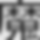

In [10]:
tempFont = ImageFont.truetype("meiryo.ttc", 50)
T = transforms.ToTensor()
reverseT = transforms.ToPILImage()
img1 = createImageRotations(
    pixelSize=40,
    symbol=u"魔",
    font=tempFont,
    yBaseOffset=-0.15,
    key=-1,
    foreground=(30,255),
    background=(235),
    angle=0,
    seed=4 #4 has a symbol lower down
)

reverseT(((255*T(img1)).byte().float())/255)

In [20]:
color_settings = [
    {'foreground':(0,255), 'background':(255)},
    {'foreground':(255,255), 'background':(0)},
    {'foreground':(90,255), 'background':(235)},
    {'foreground':(235,255), 'background':(90)}
]

rotations = [10,0,-10]

fontSizes = [0.625,0.875,1.25]

def createImage2(pixelSize=64,symbol=u"魔",key=-1,saveAsTensors=False):
    #fontSize = math.ceil(pixelSize*0.78)
    #fontOffsetX = math.floor(pixelSize*0.22/2)
    #fontOffsetY = math.floor(pixelSize*0.22/4)
    
    to_tensor = transforms.ToTensor()
    
    num_iter = 0
    for size in fontSizes:
        fontSize = math.floor(size*pixelSize)
        fonts = [
            {'font_value':ImageFont.truetype("meiryo.ttc", fontSize), 'offset':-0.15}, #Requires japanese language to be added as a language in windows options
            {'font_value':ImageFont.truetype("yumin.ttf", fontSize), 'offset':0},
            {'font_value':ImageFont.truetype("YuGothB.ttc", fontSize), 'offset':0},
            {'font_value':ImageFont.truetype("./Fonts/DelaGothicOne-Regular.ttf", fontSize), 'offset':-0.25}
            #ImageFont.truetype("YuGothM.ttc", fontSize),
            #ImageFont.truetype("msmincho.ttc", fontSize)
        ]
        
        for font_obj in fonts:
            for color_setting in color_settings:
                for rotation in rotations:

                    num_iter += 1

                    fore = color_setting['foreground']
                    back = color_setting['background']
                    
                    font = font_obj['font_value']
                    fontYOffset = font_obj['offset']
                    
                    image1 = createImageRotations(
                        pixelSize=pixelSize,
                        symbol=symbol,
                        font=font,
                        yBaseOffset=fontYOffset,
                        key=key,
                        foreground=fore,
                        background=color_setting['background'],
                        angle=rotation,
                        seed=key*num_iter
                    )

                    #filename = u"./Training_set/"+str(key) +"_"+ symbol +"_"+ font.getname()[0] +"_"+ font.getname()[1]  +"_fore("+ str(fore[0]) + ")_back("+ str(back[0]) + ")_rot(" + str(rotation) + ")"
                    filename = u"./Image_set/"+str(key) +"_"+ symbol +"_"+ str(num_iter) +"_"+ font.getname()[0] +"_"+ font.getname()[1]
                    if saveAsTensors:
                        save( (255*to_tensor(image1)).byte() , filename+".pt")
                    else:
                        image1.convert("L").save(filename+".jpg")
    

In [21]:
def sortValue(item):
    return item[1]

picturesAsTensors = True
pixelSize = 64

num2jap_dict = {}
jap2num_dict = {}
with open('memrise_rtk_kanji.csv', encoding='utf-8', mode='r') as infile:
    reader = csv.reader(infile)
    
    jap2num_dict = {rows[0]:int(rows[1]) for rows in reader}
    jap_list = list(jap2num_dict.items())
    jap_list.sort(key=sortValue)
    
    start = time.time()
    for index in range(len(jap_list)):
        symbol = jap_list[index][0]
        key = index+1
        createImage2(pixelSize=pixelSize,symbol=symbol,key=key,saveAsTensors=picturesAsTensors)
        if index%100==99:
            end = time.time()
            ratio = index/len(jap_list)
            dt = end-start
            expected_time = math.floor(dt*((1-ratio)/ratio))
            
            percent = 100*ratio
            percent = math.floor(100*percent)/100
            print(str(percent)+"% of pictures generated. Estimated time left : " 
                  + str(expected_time//60) + "m " + str(expected_time%60) + "s")
            
print("100% of pictures generated.")

4.5% of pictures generated. Estimated time left : 6m 16s
9.04% of pictures generated. Estimated time left : 6m 0s
13.59% of pictures generated. Estimated time left : 5m 45s
18.14% of pictures generated. Estimated time left : 5m 29s
22.69% of pictures generated. Estimated time left : 5m 14s
27.23% of pictures generated. Estimated time left : 4m 56s
31.78% of pictures generated. Estimated time left : 4m 40s
36.33% of pictures generated. Estimated time left : 4m 21s
40.88% of pictures generated. Estimated time left : 4m 3s
45.42% of pictures generated. Estimated time left : 3m 44s
49.97% of pictures generated. Estimated time left : 3m 25s
54.52% of pictures generated. Estimated time left : 3m 7s
59.07% of pictures generated. Estimated time left : 2m 48s
63.61% of pictures generated. Estimated time left : 2m 30s
68.16% of pictures generated. Estimated time left : 2m 11s
72.71% of pictures generated. Estimated time left : 1m 52s
77.26% of pictures generated. Estimated time left : 1m 34s
81.

In [23]:
#create csv for data loader
print("Loading files\n")
trainingPath = pathlib.Path().resolve() / "Image_set"
picturesNames = [f for f in listdir(trainingPath) if isfile(join(trainingPath, f))]

Loading files



In [24]:

with open('loader_data_train.csv', 'w', encoding='UTF8', newline='') as file_train:
    with open('loader_data_eval.csv', 'w', encoding='UTF8', newline='') as file_eval:
        # create the csv writer
        random.seed(420)
        writer_train = csv.writer(file_train)
        writer_eval = csv.writer(file_eval)

        writer_train.writerow(["filename","label"])
        writer_eval.writerow(["filename","label"])

        index = 0
        start = time.time()
        for name in picturesNames:
            # write a row to the csv file
            temp_str = [name, str(int(name.split("_")[0])-1)]
            
            if random.randrange(4) == 0:
                writer_eval.writerow(temp_str)
            else:
                writer_train.writerow(temp_str)
                
            index+=1

            if index%50000==0:
                end = time.time()
                ratio = index/len(picturesNames)
                dt = end-start
                expected_time = math.floor(dt*((1-ratio)/ratio))

                percent = 100*ratio
                percent = math.floor(100*percent)/100
                print(str(percent)+"% of csv entries generated. Estimated time left : " 
                      + str(expected_time//60) + "m " + str(expected_time%60) + "s")
        print("100% of csv entries generated.")

15.79% of csv entries generated. Estimated time left : 0m 0s
31.58% of csv entries generated. Estimated time left : 0m 0s
47.37% of csv entries generated. Estimated time left : 0m 0s
63.16% of csv entries generated. Estimated time left : 0m 0s
78.95% of csv entries generated. Estimated time left : 0m 0s
94.74% of csv entries generated. Estimated time left : 0m 0s
100% of csv entries generated.
